In [99]:
from surrogate import Surrogate
from newtons_method import NewtonsMethod
import torch
import numpy as np
import matplotlib.pyplot as plt

In [100]:
# construct two 1d surrogates following y(x) = x, using different lengthscales
x, y = torch.tensor([[-1.], [1.]]), torch.tensor([[-1.], [1.]])
surrogate_normal_ls = Surrogate(x, y, set_ls=0.5)
surrogate_small_ls = Surrogate(x, y, set_ls=0.1)

c:\Users\DeMan01\Documents\uni\masters_thesis\convergence_tests\surrogate.py:13: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  self.gp_model = SingleTaskGP(x_points, y_points, y_var, input_transform=normilisation)
c:\Users\DeMan01\Documents\uni\masters_thesis\.venv\Lib\site-packages\botorch\models\utils\assorted.py:271: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
c:\Users\DeMan01\Documents\uni\masters_thesis\.venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


In [101]:
    # choose points to apply Newtons method to
# 100 points, inclusive on both ends
point_set = torch.linspace(-1, 1, 200)
point_set = torch.unsqueeze(point_set, 1)
# point_set is copied
newton_normal = NewtonsMethod(surrogate_normal_ls, point_set)
newton_small = NewtonsMethod(surrogate_small_ls, point_set, epsilon=1e-9)

# take 50 steps for each
newton_normal.take_n_steps(500)
newton_small.take_n_steps(500)

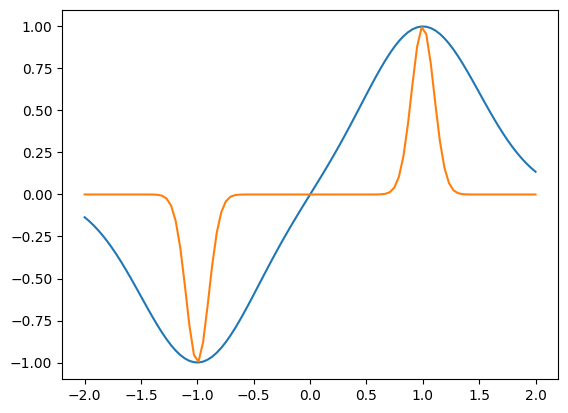

In [102]:
x = torch.linspace(-2., 2., 100)
x = torch.unsqueeze(x, 1)

with torch.no_grad():
    plt.plot(x, surrogate_normal_ls(x).detach())
    plt.plot(x, surrogate_small_ls(x).detach())
plt.show()

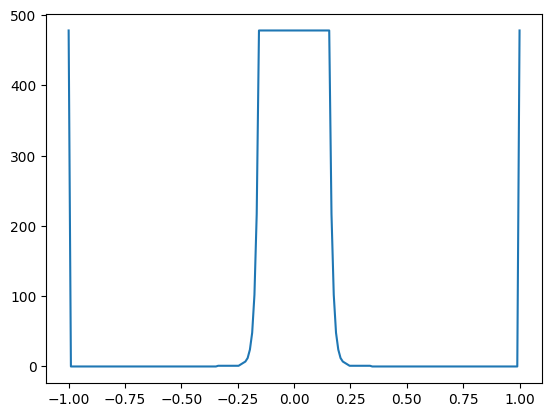

In [103]:
def decay_time_by_start(newton, decay_fac=1/2, zero_point=torch.tensor([[0]])):
    def euclidean_dist(a):
        return torch.sqrt(torch.sum((a - zero_point) ** 2, dim=1))
    halftimes = np.zeros(newton.history[0].shape[0])
    found_half = np.zeros(halftimes.shape)
    halves = euclidean_dist(newton.history[0]) * decay_fac
    for i, h in enumerate(newton.history[1:]):
        new_founds = (1 - found_half) * (euclidean_dist(h) <= halves).numpy()
        halftimes += new_founds * i
        found_half += new_founds
    return halftimes + (1 - found_half) * max(halftimes)

plt.plot(newton_small.history[0], decay_time_by_start(newton_small, decay_fac=0.999))

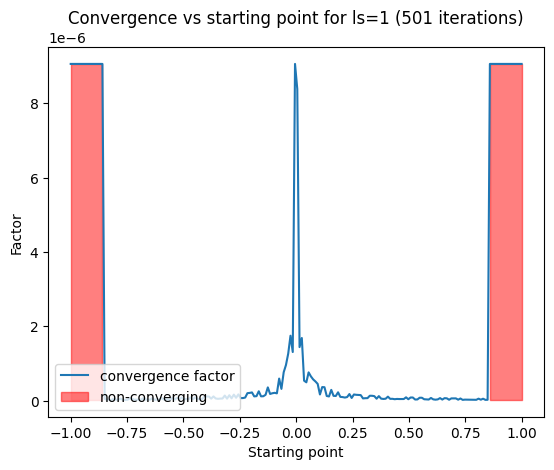

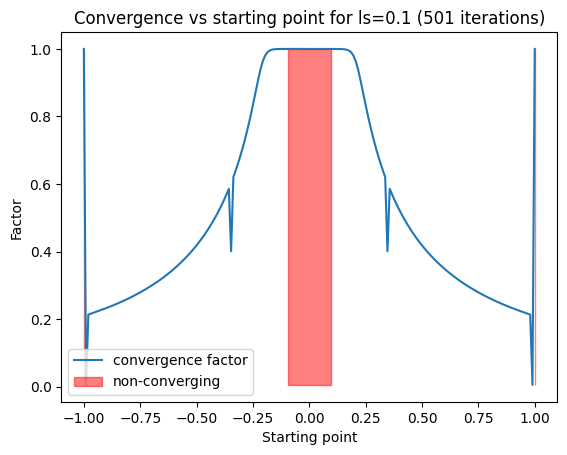

In [131]:
def conv_fac(newton, zero_point=torch.tensor([[0]])):
    def euclidean_dist(a):
        # treat nan as infinitly far away
        a = torch.nan_to_num(a, nan=torch.inf, posinf=torch.inf, neginf=-torch.inf)
        return torch.sqrt(torch.sum((a - zero_point) ** 2, dim=1))
    start_dists = euclidean_dist(newton.history[0])
    # check for convergence
    converges = (start_dists > euclidean_dist(newton.history[-1])).type(start_dists.dtype)
    sign_mask = torch.sign(start_dists)
    # make sure all values are non-zero, keeping the sign
    start_dists = (start_dists * sign_mask + 1e-9) * sign_mask
    result = euclidean_dist(newton.history[-1]) / start_dists
    # make sure we only have valid values in the array by setting all invalid values to 1
    return torch.nan_to_num(result, nan=1, posinf=1, neginf=1), converges

def plot_conv_fac(newton, name=None):
    values, converged = conv_fac(newton)
    # set values that did not converge to the max convergence value
    max_val = torch.max(values * converged)
    values = values * converged + (1 - converged) * max_val
    x = newton.history[0].squeeze()
    if name is not None:
        plt.title(f'Convergence vs starting point for {name} ({len(newton.history)} iterations)')
    else:
        plt.title(f'Convergence vs starting point ({len(newton.history)} iterations)')
    plt.plot(x, values, label='convergence factor')
    plt.fill_between(x, torch.min(values), torch.max(values), where=(converged < 0.5), color='red', alpha=0.5, label='non-converging')
    plt.legend(loc=3)
    plt.ylabel('Factor')
    plt.xlabel('Starting point')
    plt.show()

plot_conv_fac(newton_normal, 'ls=1')
plot_conv_fac(newton_small, 'ls=0.1')

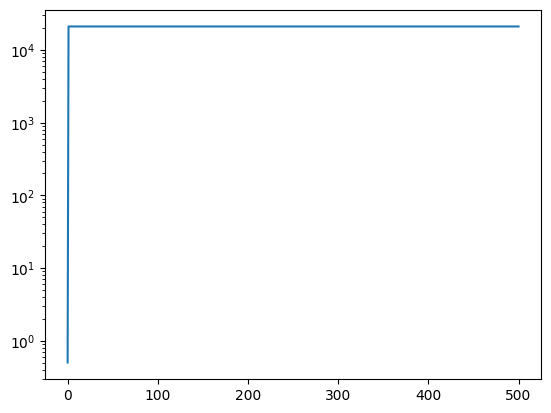

In [33]:
# function to compute mean distance for all points to the 0 point
def convergence(newtons_method, zero_point=torch.tensor([0])):
    # prepare memory needed
    result = np.empty(len(newtons_method.history))
    for i, h in enumerate(newtons_method.history):
        # mean euclidean distance from the zero point
        result[i] = torch.mean(torch.sqrt(torch.sum((h - zero_point) ** 2, dim=1)))
    return result

plt.yscale('log')
#plt.plot(convergence(newton_normal))
plt.plot(convergence(newton_small))
plt.show()